In [78]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, TransformerConv
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import lr_scheduler
from scipy import sparse
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import io, tarfile, os
import copy
from torch.nn.functional import binary_cross_entropy_with_logits as BCEwLogits
if torch.cuda.is_available():
    torch.cuda.current_device()
%env CUDA_LAUNCH_BLOCKING=1

datafile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde_HTMLgraphs.tar"

plt.ion()

SEED = 16

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

set_seed(SEED)

env: CUDA_LAUNCH_BLOCKING=1


***BELOW***
If data-loading < 5-10 % of total epoch time with num_workers=0, stick with the simple path.
Otherwise, parallel loading with share-friendly torch_sparse.SparseTensor
almost always pays off.

In [79]:
# ───────────────────────────────────────────────────────── Tar-reader dataset
class TarGraphDataset(Dataset):
    """
    Each graph is stored under its own sub-directory *inside* one .tar:

        graphs.tar
        ├── 0001/X.npz
        ├── 0001/E.npz
        ├── 0001/edge_index.npy
        ├── 0001/labels.npz
        ├── 0001/label_index.npy
        ├── 0001/label_value.npy
        ├── 0002/…
        └── …

    The tar is opened once; __getitem__ streams the six files for graph *idx*
    straight into memory, converts them to native PyTorch tensors and returns.
    """

    def __init__(self, tar_path: str | Path):
        self.tar = tarfile.open(tar_path, mode="r:*")      # gzip/none/…
        self.index: dict[str, dict[str, tarfile.TarInfo]] = {}
        self.sublen = {}

        # Build a small lookup table in RAM  {gid: {filename: tarinfo}}
        for member in self.tar.getmembers():
            if not member.isfile():
                continue

            p     = Path(member.name)
            gid   = str(p.parent)   # '0007'
            fname = p.name          # 'X.npz'

            # keep only folders that really are 4-digit graph IDs
            if gid[-4:].isdigit():
                self.index.setdefault(gid, {})[fname] = member

        self.gids = sorted(self.index)

        # Remove thos with no labels
        for gid, files in self.index.items():
            if not files.get("labels.npz"):
                self.gids.remove(gid)

        # Count
        name, counts = np.unique([Path(gid).parent.name for gid in self.gids], return_counts=True)

        # Get cumsum
        running = 0
        for lbl, cnt in zip(name, counts):
            self.sublen[lbl] = (running, running + cnt)
            running += cnt

    # ------------- helpers --------------------------------------------------
    @staticmethod
    def _npz_to_csr(buf: bytes, dtype=torch.float32):
        csr = sparse.load_npz(io.BytesIO(buf)).tocsr()
        crow = torch.from_numpy(csr.indptr.astype(np.int64))
        col  = torch.from_numpy(csr.indices.astype(np.int64))
        val  = torch.from_numpy(csr.data).to(dtype)
        return torch.sparse_csr_tensor(
            crow, col, val, size=csr.shape, dtype=dtype, requires_grad=False
        )

    @staticmethod
    def _npy_to_tensor(buf: bytes, dtype):
        arr = np.load(io.BytesIO(buf), allow_pickle=False)
        return torch.from_numpy(arr).to(dtype)

    def get_sublen(self, name):
        return self.sublen[name]

    # ------------- Dataset API ---------------------------------------------
    def __len__(self):
        return len(self.gids)

    def __getitem__(self, idx):
        gid   = self.gids[idx]
        files = self.index[gid]

        get = lambda name: self.tar.extractfile(files[name]).read()
        
        fileinfo = gid

        X   = self._npz_to_csr(get("X.npz"),       dtype=torch.float32)
        Aef = self._npz_to_csr(get("E.npz"),       dtype=torch.float32)
        Lef = self._npz_to_csr(get("labels.npz"),  dtype=torch.float32)

        Aei = self._npy_to_tensor(get("edge_index.npy"),  dtype=torch.int64)
        Lei = self._npy_to_tensor(get("label_index.npy"), dtype=torch.int64)
        y   = self._npy_to_tensor(get("label_value.npy"), dtype=torch.int64)

        return fileinfo, X, Aei.t().contiguous(), Aef, Lei.t().contiguous(), Lef, y


In [80]:
def concat_csr(blocks):
    """
    Vertically stack CSR matrices that all share the same n_cols.
    Keeps sparsity and returns a single torch.sparse_csr_tensor.
    """
    crow_bufs, col_bufs, val_bufs = [], [], []
    nnz_so_far, n_rows, n_cols = 0, 0, blocks[0].size(1)

    for k, csr in enumerate(blocks):
        crow = csr.crow_indices().clone()          # (n_rows_k + 1,)

        # 1) shift by *cumulative* nnz so far
        crow += nnz_so_far

        # 2) drop the leading 0 for every block after the first
        if k > 0:
            crow = crow[1:]

        crow_bufs.append(crow)
        col_bufs.append(csr.col_indices())
        val_bufs.append(csr.values())

        nnz_so_far += csr.values().numel()
        n_rows     += csr.size(0)

    crow_cat = torch.cat(crow_bufs)
    col_cat  = torch.cat(col_bufs)
    val_cat  = torch.cat(val_bufs)

    return torch.sparse_csr_tensor(
        crow_cat, col_cat, val_cat,
        size=(n_rows, n_cols),
        dtype=val_cat.dtype,
        device=val_cat.device,
        requires_grad=False
    )


def sparse_graph_collate(batch):
    # unpack each graph
    filenames, xs, aei, aef, lei, lef, ys = zip(*batch)

    # node-count prefix sum for shifting
    node_offsets = torch.cumsum(
        torch.tensor([0] + [x.size(0) for x in xs[:-1]]), 0)

    # ----- merge node features (CSR) -----------------------------
    X_batch = concat_csr(xs)

    # ----- merge structural edges --------------------------------
    Aei_shifted = []
    for off, ei in zip(node_offsets, aei):
        Aei_shifted.append(ei + off)   # shift both rows
    Aei_batch = torch.cat(Aei_shifted, dim=1)   # (2 , E_tot)

    Aef_batch = concat_csr(aef)

    # ----- merge label edges -------------------------------------
    Lei_shifted = []
    for off, ei in zip(node_offsets, lei):
        Lei_shifted.append(ei + off)
    Lei_batch = torch.cat(Lei_shifted, dim=1)

    Lef_batch = concat_csr(lef)
    y_batch   = torch.cat(ys)

    return filenames, X_batch, Aei_batch, Aef_batch, Lei_batch, Lef_batch, y_batch

def debug_collate(batch):
    _, xs, aei, aef, lei, lef, ys = zip(*batch)
    print("--- one mini-batch ---")
    for i, X in enumerate(xs):
        print(f"graph {i}:  nodes={X.size(0):4d}   "
              f"struct-edges={aei[i].shape[1]:4d}   "
              f"label-edges={lei[i].shape[1]:3d}")
    # then call the real collate to keep training code unchanged
    return sparse_graph_collate(batch)

# ───────────────────────────────────────────────────────── loader utilities
def identity_collate(batch):
    """batch == list of length 1 → return that single sample untouched."""
    return batch[0]

def make_loader(ds, batch_size=1, shuffle=False):
    return DataLoader(ds,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      collate_fn=sparse_graph_collate,
                      num_workers=0,
                      pin_memory=True)    # fast GPU transfer

In [81]:
# dataset   = TarGraphDataset("../../data/swde_HTMLgraphs.tar")
# loader    = make_loader(dataset, batch_size=8, shuffle=False)

# next(iter(loader))

# count = 0
# for fileinfo, X, Aei, Aef, Lei, Lef, y in loader:
#     print(fileinfo)
#     count +=1
# print(count)

In [82]:
# This is a lazy loader for individual files

# class LazyGraphDataset(Dataset):
#     """
#     Each graph lives in its own .npz / .pt / whatever on disk.
#     __getitem__ loads it just-in-time.
#     """

#     def __init__(self, folderpaths):
#         """
#         meta_csv: a CSV (or list of dicts) with columns:
#             path_X, path_A_index, path_A_feat, path_L_index, path_L_feat, path_y
#         Only these tiny strings stay in RAM.
#         """
#         self.folderpaths = list(folderpaths)

#     def _import_tensor(self, filename: str, dtype: torch.dtype, is_sparse: bool = False):
#         """
#         Load a .npz CSR matrix and return either
#         • a torch.sparse_csr_tensor              (if is_sparse=True)
#         • a torch.Tensor (dense)                 (otherwise)
#         """
#         csr = sparse.load_npz(filename).tocsr()

#         if is_sparse:
#             crow = torch.from_numpy(csr.indptr.astype(np.int64))
#             col  = torch.from_numpy(csr.indices.astype(np.int64))
#             val  = torch.from_numpy(csr.data).to(dtype)
#             return torch.sparse_csr_tensor(crow, col, val,size=csr.shape, dtype=dtype, requires_grad=False)
#         # — otherwise densify —
#         return torch.from_numpy(csr.toarray()).to(dtype)

#     def __getitem__(self, idx):
#         folder_path = self.folderpaths[idx]

#         X = self._import_tensor((folder_path/"X.npz"), torch.float32, is_sparse=False)
#         #A = self._import_tensor(folder_path/"A.npz", torch.long, True)
#         Aef = self._import_tensor((folder_path/"E.npz"), torch.float32, is_sparse=True)
#         Aei = torch.from_numpy(np.load((folder_path/"edge_index.npy")))
#         Lef = self._import_tensor((folder_path/"labels.npz"), torch.float32, is_sparse=True)
#         Lei = torch.from_numpy(np.load((folder_path/"label_index.npy")))
#         y = torch.from_numpy(np.load((folder_path/"label_value.npy")))

#         return X, Aei, Aef, Lei, Lef, y

#     def __len__(self):
#         return len(self.folderpaths)

# def graph_collate(batch):
#     # batch is a list of tuples
#     xs, aei, aef, lei, lef, ys = zip(*batch)   # tuples of length B

#     return (list(xs),                          # list of sparse X
#             list(aei),                         # list of edge_index
#             list(aef),                         # list of sparse A_edge_feat
#             list(lei),
#             list(lef),
#             list(ys))                          # dense y can still be list/stack

# def make_loader(dataset, batch_size=1, shuffle=False):
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=graph_collate, num_workers=0, pin_memory=True)

In [83]:
# def walk_limited(root: Path, max_depth: int, pat: str):
#     root_depth = len(root.parts)
#     for dirpath, dirnames, _ in os.walk(root):
#         depth = len(Path(dirpath).parts) - root_depth
#         if depth > max_depth:
#             # prune traversal
#             dirnames[:] = []
#             continue
#         for d in dirnames:
#             p = Path(dirpath, d)
#             if p.match(pat):
#                 yield p

# src = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_HTMLgraphs/movie/movie")
# batch_dirs = list(walk_limited(src, max_depth=2, pat='[0-9][0-9][0-9][0-9]'))
# print(src.exists())
# batchFiles = list(src.rglob("[0-9][0-9][0-9][0-9]"))
# print(len(batchFiles))
# dataset = LazyGraphDataset(batchFiles)
# dataloader = make_loader(dataset, batch_size=1, shuffle=False)

In [84]:
# for Xs, Aeis, Aefs, Leis, Lefs, ys in dataloader:
#     print(Xs[0].shape, Aeis[0].shape, Aefs[0].shape, Leis[0].shape, Lefs[0].shape, ys[0].shape)
#     break

In [85]:
# # Helper function to normalise the A matrix
# def symmetric_normalize(A_tilde):
#     """
#     Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
#       A_norm = D^{-1/2} * A_tilde * D^{-1/2}
#     Where D_{ii} = sum of row i in A_tilde.

#     A_tilde (N, N): Adj. matrix with self loops
#     Returns:
#       A_norm : (N, N)
#     """

#     eps = 1e-5
#     d = A_tilde.sum(dim=1) + eps
#     D_inv = torch.diag(torch.pow(d, -0.5))
#     return (D_inv @ A_tilde @ D_inv).to(torch.float32)

In [86]:
def plot_metrics_live(
    train_vals,
    val_vals,
    save_path,
    xlabel="Epoch",
    ylabel="Metric",
    title="Training & Validation",
    fig_ax=None
):
    """
    Live‐updating single‐axis plot of training vs validation values.
    Call each epoch with the growing lists `train_vals` and `val_vals`.
    Returns (fig, ax) so you can pass them back in.
    """
    # First call: create figure & axis
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
    else:
        fig, ax = fig_ax

    # Clear and redraw
    ax.cla()
    epochs = range(1, len(train_vals) + 1)

    ax.plot(epochs, train_vals, '-o', label="Train", markersize=4)
    ax.plot(epochs, val_vals,   '-s', label="Val",   markersize=4)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc="best")

    fig.tight_layout()

    fig.savefig(Path(save_path), dpi=150)

    return fig, ax


In [ ]:
# To advance the model, use the methods in https://arxiv.org/pdf/2311.02921

class GraphAttentionNetwork(nn.Module):
    """
    HTML‑graph model

        X  ─╮
            │  GAT( 96 → 64 )
            │  ReLU
            │  GAT( 64 → 32 )
            │  ReLU
            └─ Edge‑feature constructor
                      [h_i ‖ h_j ‖ φ(e_ij)] ─► MLP(69 → 1)

    Parameters
    ----------
    in_dim          : node‑feature size   (= 96)
    edge_in_dim     : raw edge‑feature size (= 197)
    edge_emb_dim    : Edge-feature MLP output dims
    """
    def __init__(self,
                 in_dim: int        = 96,
                 edge_in_dim: int   = 197,
                 edge_emb_dim: int  = 8,
                 hidden1: int       = 128,
                 hidden2: int       = 64,
                 hidden3: int       = 32,
                 heads:  int        = 4):
        super().__init__()

        # ── Node-level encoder (edge-aware) ────────────────────────────
        self.tr1 = TransformerConv(
            in_channels      = in_dim,
            out_channels     = hidden1,
            heads            = heads,
            edge_dim         = edge_emb_dim,
            dropout          = 0.1,
            beta             = True         # learnable α in α·x + (1-α)·attn
        )
        self.tr2 = TransformerConv(
            in_channels      = hidden1 * heads,
            out_channels     = hidden2,
            heads            = heads,
            edge_dim         = edge_emb_dim,
            dropout          = 0.1,
            beta             = True
        )
        self.tr3 = TransformerConv(
            in_channels      = hidden2 * heads,
            out_channels     = hidden3,
            heads            = 1,
            edge_dim         = edge_emb_dim,
            dropout          = 0.1,
            beta             = True
        )

        # ── Edge feature projector ────────────── (It is not an explicit linear layer as it works on a sparse matrix)
        self.W_edge = nn.Parameter(torch.empty(edge_in_dim, edge_emb_dim))
        nn.init.xavier_uniform_(self.W_edge)

        # ── Edge-level MLP decoder (unchanged) ────────────────────────
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden3 * 2 + edge_emb_dim, hidden3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden3, 1)
        )

    # ---------------------------------------------------------------------

    def forward(
        self,
        x_dense: torch.Tensor,        # (N_nodes, 96)          sparse
        A_edge_index: torch.Tensor,   # (2, nnz_A)             COO  (from A)
        A_edge_attr: torch.Tensor,    # (nnz_A, 197)           dense / sparse.mm
        E_edge_index: torch.Tensor,   # (2, N_E)               candidates
        E_edge_attr: torch.Tensor     # (N_E, 197)             sparse features
    ):
        # 1) node features
        #x = x_sparse.to_dense()
        A_edge_emb = torch.sparse.mm(A_edge_attr, self.W_edge)     # (nnz_A , 8)
        
        # 2) edge-aware GATv2 layers
        h = F.relu( self.tr1(x_dense, A_edge_index, A_edge_emb) )
        h = F.relu( self.tr2(h,        A_edge_index, A_edge_emb) )
        h = F.relu( self.tr3(h,        A_edge_index, A_edge_emb) )

        # 3) candidate-edge projection  φ(E) = E @ W_edge
        E_edge_emb = torch.sparse.mm(E_edge_attr, self.W_edge)     # (N_E , 8)
        
        # 4) gather node embeddings and classify
        src, dst = E_edge_index
        z = torch.cat([h[src], h[dst], E_edge_emb], dim=1)      # (N_E , 72)
        return self.edge_mlp(z).squeeze(-1)                   # (N_E ,) returns the logits

In [88]:
CLIP_NORM = 1.0           # gradient clipping

# ---------- one epoch --------------------------------------------------------
def train_epoch(model, loader, optimizer,
                criterion=BCEwLogits, device="cpu"):

    model.train()
    running_loss, running_edges = 0.0, 0
    count = 0
    l = len(loader)

    for _, X, Aei, Aef, Lei, Lef, y in loader:
        count += 1
        X, Aei, Aef = X.to(device), Aei.to(device), Aef.to(device)
        Lei, Lef, y = Lei.to(device), Lef.to(device), y.to(device)

        optimizer.zero_grad()
        
        logits = model(X, Aei, Aef, Lei, Lef)          # (N_label,)
        loss   = criterion(logits, y.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()

        running_loss  += loss.item() * y.numel()
        running_edges += y.numel()

        if count % 20 == 0:
            print(f"epoch {count}/{l} "
                    f"loss={loss:.4f}")

    return running_loss / running_edges


# ---------- evaluation -------------------------------------------------------
@torch.no_grad()
def eval_edge_model(model, loader, criterion, device="cpu", thr=0.5):
    model.eval()
    TP = FP = FN = 0
    running_loss, running_edges = 0.0, 0

    filenames = []
    for f, X, Aei, Aef, Lei, Lef, y in loader:
        filenames += f
        X, Aei, Aef = X.to(device), Aei.to(device), Aef.to(device)
        Lei, Lef, y = Lei.to(device), Lef.to(device), y.to(device)

        logits = model(X, Aei, Aef, Lei, Lef)
        loss   = criterion(logits, y.float())
        running_loss  += loss.item() * y.numel()
        running_edges += y.numel()
        probs  = torch.sigmoid(logits)

        pred = (probs >= thr).long()
        TP  += ((pred == 1) & (y == 1)).sum().item()
        FP  += ((pred == 1) & (y == 0)).sum().item()
        FN  += ((pred == 0) & (y == 1)).sum().item()

    print(f"Validating {np.unique([filename[:-5] for filename in filenames])} website type")
    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return running_loss / running_edges, prec, rec, f1

In [89]:
def train_model(model,
                train_loader,
                val_loader,
                load_checkpoint,
                num_epochs     = 100,
                lr             = 1e-3,
                validate_every = 10,
                patience       = 10,
                device         = "cpu"):

    print("Woo lets go")

    model_path = "./model_in_training.pt"
    if os.path.exists(model_path) and load_checkpoint:
        print("loading existing model...")
        model.load_state_dict(torch.load(model_path))

    model.to(device)
    
    opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = lr_scheduler.ReduceLROnPlateau(opt, mode="max",
                                          patience=patience, factor=0.5)
    criterion = BCEwLogits

    best_f1, fig_ax, best_state, train_loss, val_loss = 0.0, None, None, [], []

    for epoch in range(1, num_epochs + 1):
        
        loss = train_epoch(model, train_loader, opt, criterion=criterion, device=device)
        train_loss.append(loss)

        if epoch % validate_every == 0 or epoch == num_epochs:
            loss, p, r, f1 = eval_edge_model(model, val_loader, criterion, device=device)
            val_loss.append(loss)
            sched.step(f1)

            lr_now = opt.param_groups[0]["lr"]
            print(f"Epoch {epoch:03d}/{num_epochs} "
                  f"loss={loss:.4f}  P={p:.3f} R={r:.3f} F1={f1:.3f}  lr={lr_now:.2e}")

            if f1 > best_f1:
                best_f1, best_state = f1, copy.deepcopy(model.state_dict())

            # if lr_now < 1e-5:
            #     print("Stop: LR < 1e-5")
            #     break

            fig_ax = plot_metrics_live(
                train_loss,
                val_loss,
                "CurrentRun",
                xlabel="Epoch",
                ylabel="Loss",
                title="Model Performance",
                fig_ax=fig_ax
            )
            
            if load_checkpoint:
                with torch.no_grad():
                    torch.save(model.state_dict(), model_path)

    if best_state is not None:
        model.load_state_dict(best_state)

    return best_state, train_loss, val_loss, fig_ax


Woo lets go
epoch 20/100 loss=0.5291
epoch 40/100 loss=0.5210
epoch 60/100 loss=0.4657
epoch 80/100 loss=0.4890
epoch 100/100 loss=0.4502
Validating ['swde_HTMLgraphs/movie/movie/movie-allmovie(2000)'] website type
Epoch 001/250 loss=0.8544  P=0.019 R=0.000 F1=0.001  lr=1.00e-02
epoch 20/100 loss=0.4030
epoch 40/100 loss=0.3837
epoch 60/100 loss=0.4391
epoch 80/100 loss=0.3772
epoch 100/100 loss=0.3493
Validating ['swde_HTMLgraphs/movie/movie/movie-allmovie(2000)'] website type
Epoch 002/250 loss=1.2735  P=0.350 R=0.071 F1=0.119  lr=1.00e-02
epoch 20/100 loss=0.3401
epoch 40/100 loss=0.3450
epoch 60/100 loss=0.3245
epoch 80/100 loss=0.3258
epoch 100/100 loss=0.3096
Validating ['swde_HTMLgraphs/movie/movie/movie-allmovie(2000)'] website type
Epoch 003/250 loss=1.4491  P=0.464 R=0.045 F1=0.082  lr=1.00e-02
epoch 20/100 loss=0.2976
epoch 40/100 loss=0.3085
epoch 60/100 loss=0.3337
epoch 80/100 loss=0.3292
epoch 100/100 loss=0.3069
Validating ['swde_HTMLgraphs/movie/movie/movie-allmovie(20

KeyboardInterrupt: 

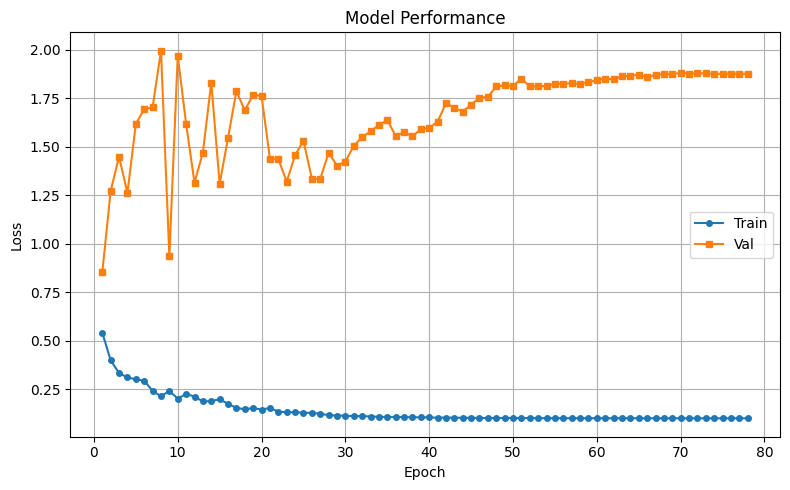

In [90]:
dataset = TarGraphDataset(datafile)
N = len(dataset)
# n_train = int(0.95 * N)
# n_val   = N - n_train
# train_ds, val_ds = random_split(dataset, [n_train, n_val])
val_start, val_end = dataset.get_sublen('movie-allmovie(2000)')
val_idx = list(range(val_start, val_end))  
train_idx = list(set(range(N)) - set(val_idx))
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = make_loader(train_ds, batch_size=256, shuffle=True)
val_loader = make_loader(val_ds, batch_size=256, shuffle=True)

model = GraphAttentionNetwork(in_dim = 96, edge_in_dim = 197, edge_emb_dim = 8, hidden1 = 64, hidden2 = 32, heads = 1)

load_checkpoint = True
_, trainloss, valloss, fig_ax = train_model(model,
            train_loader,
            val_loader,
            load_checkpoint,
            num_epochs     = 250,
            lr             = 1e-2,
            validate_every = 1,
            patience       = 5,
            device         = "cuda")

In [ ]:
#Save model
torch.save(model.state_dict(), "modelsmallerGAT.pt")